In [35]:
from ThesisPackage.Environments.multi_pong_sender_receiver_ball_onehot import PongEnvSenderReceiverBallOneHot
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os

In [36]:
def make_env():
    sequence_length = 1
    vocab_size = 3
    max_episode_steps = 512
    env = PongEnvSenderReceiverBallOneHot(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    # env = ParallelFrameStack(env, 4)
    return env

In [37]:
def load(path="models/checkpoints"):
    env = make_env()
    models = {}
    for model in os.listdir(path):
        if "pong" in model:
            state_dict = torch.load(os.path.join(path, model))
            timestamp = model.split("_")[-1]
            timestamp = int(timestamp.split(".")[0])
            agent = PPO_Multi_Agent_Centralized(env, device="cpu")
            agent.agent.load_state_dict(state_dict)
            models[timestamp] = agent
    return models

In [38]:
num_steps = 10000
agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/Multi_Pong/Sequence_Length_1")
agent_indizes = list(agents.keys())
agent_indizes.sort()
print(agent_indizes)
env = make_env()

[152, 304, 456, 608, 760, 912, 1064, 1216, 1368, 1520, 1672, 1824, 1976, 2128, 2280, 2432, 2584, 2736, 2888, 3040, 3192, 3344, 3496, 3648, 3800, 3952, 4104, 4256, 4408, 4560]


/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [39]:
def test(agent, timesteps=1024, sequence_length=1, vocab_size=3, tracking_agent="paddle_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    for timestep in range(timesteps):
            
        traking_index = env.agents.index(tracking_agent)
        tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
        obs = [obs]
        state = [state]
        obs = np.array(flatten_list(obs))
        state = np.array(flatten_list(state))

        obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
        logits = agent.agent.actor(obs_track)

        grad_tensor = torch.zeros_like(logits)
        grad_tensor[:, :-1 * sequence_length * vocab_size] = 1

        logits.backward(grad_tensor)

        saliency = obs_track.grad.data.abs()

        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

        average_language = np.sum(saliency[:, -1 * sequence_length * vocab_size:])

        obs = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
            actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

        actions = actions[0]
        actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

        saliencies.append(average_language)
        full_saliences.append(saliency)

        obs, _, truncations, terminations, infos = env.step(actions)
        state = env.state()

        if any([truncations[agent] or terminations[agent] for agent in env.agents]):
            average_length.append(timestep)
            obs, info = env.reset()
    full_saliences = np.stack(full_saliences, axis=0)
    return saliencies, average_length, full_saliences, np.array(tokens)

In [57]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation#
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(25, 5))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    rect = plt.Rectangle((-0.1, 9.5), data_reshaped.shape[0] - 1.4, 2.99, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

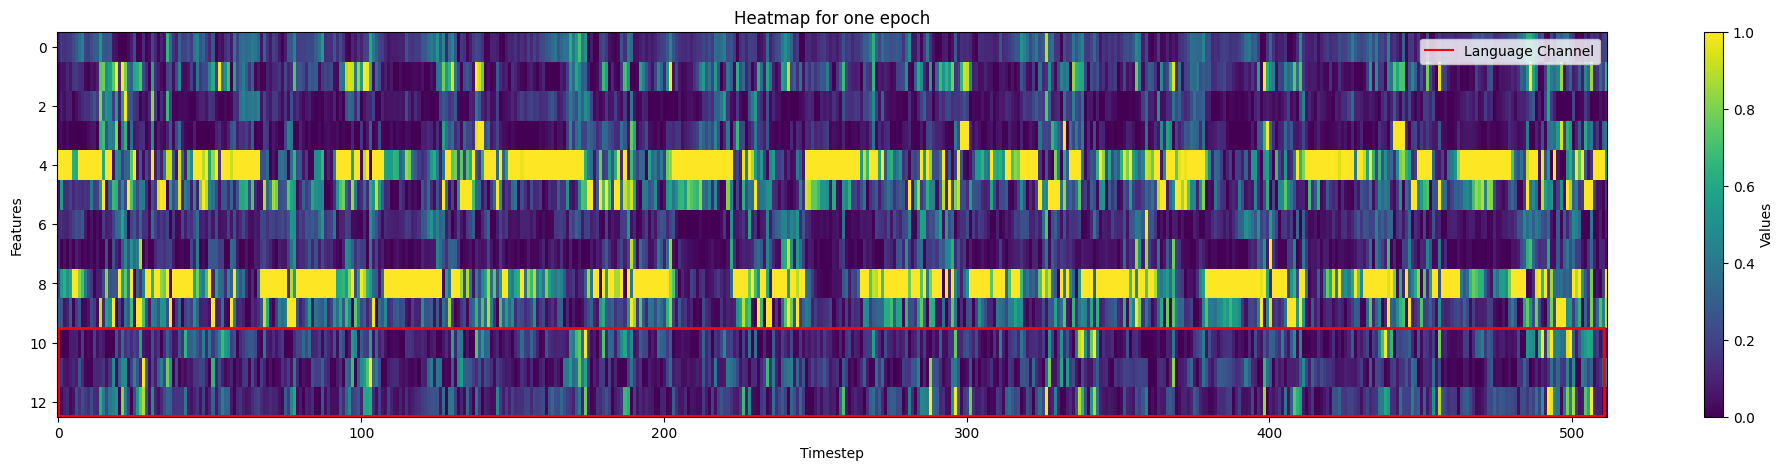

In [58]:
saliencies, average_length, full_saliences, tokens = test(agents[agent_indizes[-1]], timesteps=512)
plot_saliencies(full_saliences)

In [42]:
from tqdm import tqdm
number_of_important_saliencies = {}

for index, agent in tqdm(agents.items(), desc="Processing agents"):
    saliencies, average_length, full_saliences, tokens = test(agent, timesteps=10000)
    number_of_important_saliencies[index] = (np.array(saliencies) > 0.8).sum()

print(number_of_important_saliencies)

Processing agents: 100%|██████████| 30/30 [01:59<00:00,  3.97s/it]

{3648: 1818, 4560: 1824, 456: 543, 912: 1880, 2736: 2158, 2128: 1892, 3344: 1996, 760: 1649, 1672: 2006, 1520: 2042, 1824: 2021, 3496: 1948, 3800: 1895, 2888: 2203, 4408: 1858, 304: 272, 152: 421, 4104: 1865, 1368: 2320, 2280: 2431, 3952: 1901, 4256: 1864, 608: 1075, 1976: 1988, 3040: 2276, 3192: 2227, 1064: 2071, 2584: 2388, 1216: 2102, 2432: 2404}


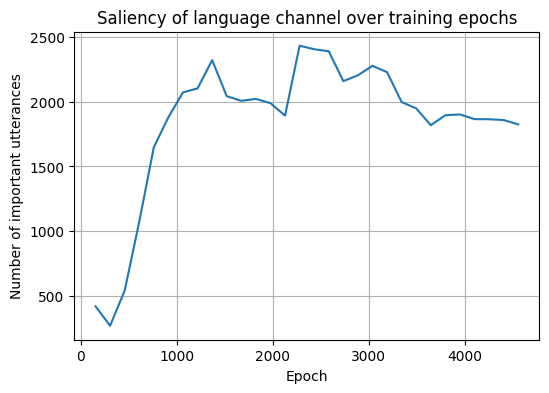

In [44]:
# Sort the dictionary by keys (indices)
sorted_data = dict(sorted(number_of_important_saliencies.items()))

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(sorted_data.keys(), sorted_data.values())
plt.xlabel('Epoch')
plt.ylabel('Number of important utterances')
plt.title('Saliency of language channel over training epochs')
plt.grid(True)
plt.savefig("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/important_utterances_1.pdf")
